# Notebook for tutorial of `TORIC` setup   
This notebook walks you through setup from source eqdsk files , to configuring `TORIC` input files, launching a run and analyzing the results.

This notebook assumes it is running on the engaging MIT cluster.

In the next cell, you specify variables to configure your run. 

In [3]:
!pwd

/home/jcwright/SPARC/TSC-V2h01


In [5]:
workdir='./run6_test'
eqdsk_file='TRANSPrun.geq'

profile_file='TRANSPrun.pkl' #or 'select'  or "Name.equidt" or "Name.txt"
#If file ends in pkl assume it is a pkl file with profile info from a prior Transp run that has fields
# rho_tor, rho_pol, te, ne, ti,ni

#If file ends in equidt assume it is already a prepared TORIC input file of profile info containing species
#information as well.

#If end is txt assume columnated data of r/a te ne ti in some order (note ni is set by concentration and quasineutrality)

#If any other , ignore and provide selection for profiles.


nspec = 3 
iatm = [2,3,3]
iazi = [1,1,2]

kdiff_itemp=1
kdiff_idens=1

kpar_ant = 11.5  #note toric reports kpar_axis, we use kpar_antenna here to set nphi in the input deck
toric_mesh = [400, 128] # Psi, theta resolution. Theta must be power of 2.
min_conc = 3 #percent #assume third or specify min species index

## Requirements

Load required python modules:
- matplotlib: for plotting
- numpy: for array math
- plasma, periodictable.elements, f90nml and fortranformat: plotting eqdsk files, preparing toric inputs and plotting outputs
- subprocess for running utility to prepare toric input
You can source /home/jcwright/bin/m_jupyter_toric to load most of these.

In [3]:
#local installs if needed
!git clone https://github.com/jcwright77/plasma.git
!python3 -m pip install --user fortranformat
!python3 -m pip install --user f90nml
!python3 -m pip install --user periodictable


fatal: destination path 'plasma' already exists and is not an empty directory.


In [4]:
#Required python modules
import sys,os
sys.path.insert(0,os.getcwd()+'/plasma')
import matplotlib.pyplot as plt
import numpy as np
import scipy
import f90nml
from periodictable import elements
from IPython.display import Markdown as md
import equilibrium_process as eqdsk
import subprocess
import toric_tools as toric

In [5]:
#Routine to be moved to plasma routines
def print_vector(nrep,fstr,a):
    """
    Converts an array of numbers into a string formated by fstr with nrep values per line.
    """
    n=a.size
    pa=""
    ta=a.reshape((a.size),order='F')
    for j in range(0,n,nrep):
        pa=pa+ "".join(map(lambda f: fstr % f, ta[j:min(j+nrep,n)]))+"\n"
    return pa

def write_profnt(namelist,equidt,version='profnt2'):
    """
    Inputs:
        namelist: as created by f90nml from toric.inp
        equidt: python dictionary of profiles to write out
            psipro: sqrt(Psipol/Psipol[a])
            tbne: [cm-3] on psipro mesh
            tbte: [keV]  on psipro mesh
            iatm: array of atomic masses/ (C12/12)
            iazi: array of atomic numbers
            tbni: ion densities on psipro mesh
            tbi_provv: ion temperatures on psipro mesh
            nspec: number of ion species
            
         version: Generally format2 is used. File is self describing in number of elements and profiles.
    """

    filename=namelist['equidata']['profnt_file']
    with open(filename,'w') as of:
        nprodt=equidt['psipro'].size
        profiles=['psipro','tbne','tbte','tbi_provv']
        if version=='profnt1':
            for profile in profiles:
                of.write('{:<10s}{:4d}\n'.format(profile, nprodt ))
                of.write(print_vector(5,'%16.9e',equidt[profile]))

        if version=='profnt2':
            nspec=equidt['nspec']
            mainsp=1
            namelist['equidata']['mainsp']=mainsp
            kdiff_idens=equidt['kdiff_idens'] #0 #specify concentrations
            kdiff_itemp=equidt['kdiff_itemp'] #0 #one ion temp
            of.write('{:<10s}{:4d}{:4d}{:4d}{:4d}{:4d}\n'.format('profnt_py',nprodt,nspec,
                                                                 mainsp,kdiff_idens,kdiff_itemp))
            for isp in range(nspec):
                of.write('{:4d}{:4d}\n'.format(int(equidt['iatm'][isp]),int(equidt['iazi'][isp])) )
            profiles=['psipro','tbne','tbte']
            for profile in profiles:
                of.write('{:<10s}{:4d}\n'.format(profile, nprodt ))
                of.write(print_vector(5,'%16.9e',equidt[profile]))
#write ion densities
            for isp in range(nspec):
#                of.write('{:<10s}\n{:4d}\n'.format('ion_conc',equidt['aconc'][isp]) )
#                of.write('{:<10s}\n{:16.9e}\n'.format('ion_conc',equidt['tbni'][0,isp]/equidt['tbne'][0]) )
                if kdiff_idens==0:
                    of.write('{:<10s}\n'.format('ni_conc'+str(isp)))
                    of.write('%16.9e \n' % equidt['tbni'][isp]) 
                else:
                    of.write('{:<10s}\n'.format('tbni'+str(isp)))
                    of.write(print_vector(5,'%16.9e',equidt['tbni'][:,isp]))
                if kdiff_itemp==0 and isp==0:
                    of.write('{:<10s}\n'.format('ion_temp') )
                    of.write(print_vector(5,'%16.9e',equidt['tbi_provv'])) 
#write ion temperatures
                if kdiff_itemp==1:
                    of.write('{:<10s}\n'.format('ion_temp'+str(isp)) )
                    of.write(print_vector(5,'%16.9e',equidt['tbi_provv'][:,isp])) 


                
                
def read_equidt(filename):
    import fortranformat as ff
    equidt={}
    with open(filename,'r') as of:
        line = of.readline()
        reader = ff.FortranRecordReader('(A10,5i4)')
        var_name, nprodt, nspec, mainsp,kdiff_idens, kdiff_itemp = reader.read(line)
        
            
        line = of.readline()
        reader = ff.FortranRecordReader('(A10,5i4)')

        if var_name=='Rfxqlo_Pro':
        #  DMC -- define flag to indicate TRANSP format variant
            print(' Detected: TRANSP "Rfxqlo_Pro" file format variant!')
            kdiff_itemp = 1
            kdiff_idens = 1
            rfxqlo_pro_variant = True
        else:
            rfxqlo_pro_variant = False

        if kdiff_itemp==0:
            nsptmp = 1
        else:
            nsptmp = 10 # place holder nspec



## Process magnetic equilibrium
There are analytic equilibria but here we will process and viz an g-eqdsk file.

### Generate toric magnetic equilibrium 
Plot equilibrium and replace limiter. Then convert to fourier representation used by TORIC with geqxpl utility.

Below we see that the original first time slice limiter is wrong. Toric input routines will flag this and exit.


In [6]:
!pwd

/home/jcwright/SPARC/TSC-V2h01


In [7]:
!cp /home/software/psfc/local/share/equigs_gen.ind $workdir
equigs_file=eqdsk_file+'.equigs'
current_dir=os.getcwd()
os.chdir(workdir)

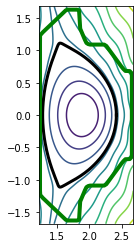

In [8]:
eq0,fig0=eqdsk.readGEQDSK(eqdsk_file,doplot=True,dolimiter=True);

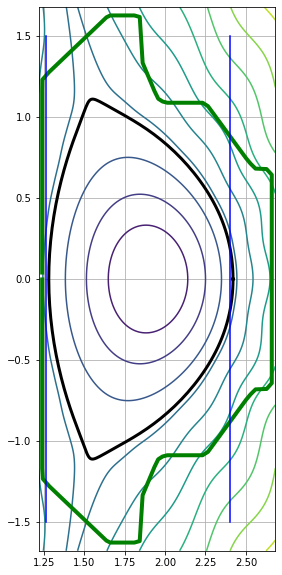

In [9]:
fig0.set_size_inches(5,10)
ax=fig0.get_axes()[0]
ax.grid()
ax.plot([2.4,2.4],[-1.5,1.5],'b')
ax.plot([1.85-0.585,1.85-0.585],[-1.5,1.5],'b')
fig0

In [10]:
print(str(subprocess.run(["geqxpl @equigs_gen/g_filename="+eqdsk_file+"/equigs_filename="+equigs_file], 
                   shell=True, stdout=subprocess.PIPE).stdout, "utf-8" ) )

  
  G-EQdsk data accepted, maximum rel. GS error:   0.495642999090293     
  
  Bphi is counter-clockwise viewed from above (nsnccwb = 1)
  
  Jphi is counter-clockwise viewed from above (nsnccwi = 1)
  
 equigs_write completion code (0=normal):           0



## Create output files

In [11]:
toric.__file__

'/home/jcwright/SPARC/TSC-V2h01/plasma/toric_tools.py'

Create toric object and read in equigs file created by geqxpl utility.

In [12]:
case=toric.toric_analysis(mode='ICRF')

CRITICAL:  toric.ncdf  not found.
Non-CRITICAL:  ./toric_qlde.cdf  not found.


In [13]:
case.idebug=False
case.read_equigs(equigsfile=equigs_file)

In [14]:
os.getcwd()

'/home/jcwright/SPARC/TSC-V2h01/run6_test'

#### Create mappings between r/a, rhopol=root(psipol), rhotor=root(psitor)

In [15]:
nmhd=case.equigs['nmhd']
imom=case.equigs['imom']

rmc2d0 =case.equigs['rzmcs2d'][0:nmhd]  #center of each flux surface. first term is magnetic axis.
zmc2d0 =case.equigs['rzmcs2d'][nmhd:2*nmhd]

print(case.equigs['rzmcs2d'][2*nmhd:].shape/imom/4)
rz=case.equigs['rzmcs2d'][2*nmhd:].reshape( (nmhd,4,imom), order='F' )
Raxis=rmc2d0[0]
rminor= (np.sum(rz[:,0,:],1)+ rmc2d0) - Raxis
print ('minor/Major radius: ',rminor[-1],Raxis, eq0['rmaxis'], eq0['rcentr'])

[151.]
minor/Major radius:  0.5072690061220002 1.91278192 1.91312441 1.85060378


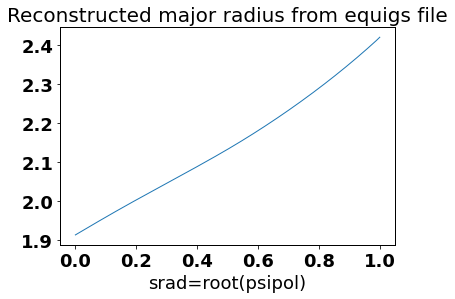

In [16]:
plt.plot(case.equigs['srad'],np.sum(rz[:,0,:],1) + rmc2d0) 
plt.title('Reconstructed major radius from equigs file');
plt.xlabel('srad=root(psipol)');

In [17]:
#map profiles vs r/a to rhopol (sqrt(Psi/Psilim))
from   scipy.interpolate import interp1d
rhopol = case.equigs['srad']
rhor = rminor #TORIC fit
rhotor = case.equigs['rhotor']
PtoTmap = interp1d(rhopol,rhotor,kind='cubic',bounds_error=False,fill_value=0.0)
rtoPmap = interp1d(rhor,  rhopol,kind='cubic',bounds_error=False,fill_value=1.0)

Ptormap = interp1d(rhopol,  rhor,kind='cubic',bounds_error=False,fill_value=rhor[-1])

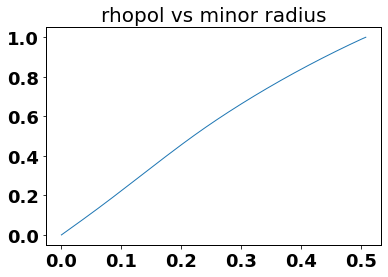

In [18]:
plt.plot(rminor,rtoPmap(rminor))
plt.title("rhopol vs minor radius");

In [19]:
Ptormap(np.linspace(0,1,20))

array([0.        , 0.02421263, 0.04810328, 0.07148202, 0.09432171,
       0.1168191 , 0.13920484, 0.16169811, 0.18448212, 0.20774234,
       0.23185645, 0.25711681, 0.28356376, 0.31121849, 0.34010756,
       0.370307  , 0.40194562, 0.43512619, 0.47000388, 0.50726901])

In [1]:
import pickle

In [2]:
with open(profile_file, 'rb') as file:
        try:
            profiles=pickle.load(file)
        except EOFError:
            pass

NameError: name 'profile_file' is not defined

In [22]:
profiles.keys()

dict_keys(['rho_tor', 'vol_zone', 'te', 'ti', 'ne', 'Zeff', 'nD', 'nT', 'nZ', 'nZ_zave_vol', 'nHe3', 'tHe3', 'nHe4_fast', 'nHe4_thermal', 'WHe3_perp', 'WHe3_par', 'WHe4_perp', 'WHe4_par', 'FastAlpha_source', 'Pich_min', 'chi_e', 'chi_i', 'jtor', 'jtor_b', 'Bt_ext', 'Bt_plasma', 'Rmajor', 'timeExtracted', 'P_LCFS', 'W_th', 'W_tot', 'li1', 'li3', 'rho_pol', 'pol_flux', 'q', 'shat', 'rmin', 'Rmax', 'Rmin', 'Zmax', 'Zmin', 'timeLastSawtooth', 'timeRangeExtracted'])

Note the profiles['rmin'] is an average radius quantity used in transport analysis and not a true radius.

In [23]:
eq0.keys()

dict_keys(['nW', 'nH', 'nbbbs', 'limitr', 'rdim', 'zdim', 'rcentr', 'rleft', 'zmid', 'rmaxis', 'zmaxis', 'simag', 'sibry', 'bcentr', 'current', 'fpol', 'pres', 'ffprim', 'pprime', 'psizr', 'qpsi', 'rbbbs', 'zbbbs', 'rlim', 'zlim', 'r', 'z', 'fluxGrid', 'iiInside'])

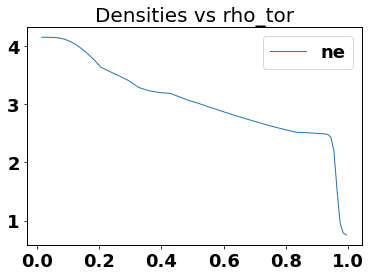

In [24]:
plt.plot(profiles['rho_tor'],profiles['ne'],label='ne') #looks like 1e20 units
plt.title('Densities vs rho_tor')
plt.legend();

array([0.02160237, 0.03607057, 0.05052128, 0.06487812, 0.07917478,
       0.09347048, 0.10776363, 0.12204809, 0.13632829, 0.15060297,
       0.1648734 , 0.17914035, 0.19340138, 0.20765023, 0.2218789 ,
       0.2360817 , 0.25025742, 0.26440983, 0.27854628, 0.29266795,
       0.30676159, 0.32081647, 0.33483699, 0.34883058, 0.36280089,
       0.37674767, 0.39066773, 0.40454985, 0.41837844, 0.43213334,
       0.44578906, 0.45931639, 0.47268601, 0.48587126, 0.49885429,
       0.51162398, 0.52417529, 0.5365076 , 0.54862419, 0.56053118,
       0.57223516, 0.58374485, 0.59506922, 0.60621741, 0.61719598,
       0.62801018, 0.63866368, 0.64915968, 0.65949981, 0.6696859 ,
       0.67971882, 0.6896002 , 0.69933131, 0.70891312, 0.71834663,
       0.7276331 , 0.73677365, 0.74576912, 0.75462063, 0.7633289 ,
       0.77189524, 0.78032017, 0.78860482, 0.79675012, 0.80475645,
       0.81262528, 0.820357  , 0.82795304, 0.83541424, 0.84274147,
       0.84993573, 0.85699807, 0.86392858, 0.87072805, 0.87739

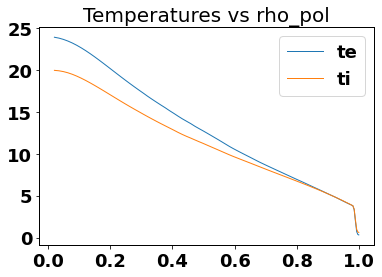

In [25]:
plt.plot(profiles['rho_pol'],profiles['te'],label='te')
plt.plot(profiles['rho_pol'],profiles['ti'],label='ti');
plt.title('Temperatures vs rho_pol')
plt.legend();
profiles['rho_pol']

In [26]:
B,GP,FRZ,Rv,Zv=eqdsk.getModB(eq0)
Rv.shape,B.shape

((265, 265), (265, 265))

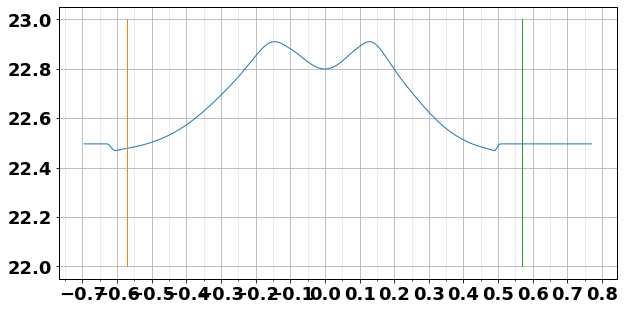

In [27]:
dims=Rv.shape
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-1, 1, 0.1)
minor_ticks = np.arange(-1, 1, 0.05)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(major_ticks)
#ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='major')
ax.grid(which='minor',alpha=0.3)

plt.plot(Rv[int(dims[0]/2),:]-eq0['rmaxis'],FRZ[int(dims[0]/2),:]);
plt.plot([-0.57,-0.57],[22,23])
plt.plot([0.57,0.57],[22,23]);

### Modify input file to run `TORIC`

In [28]:
toricnml=f90nml.read('/home/jcwright/etc/TORIC/torica_sparc.inp.template')

In [29]:
print(toricnml)

&toric_mode
    toricmode = 'toric'
/

&toricainp
    nvrb = 3
    nelm = 320
    ntt = 128
    nmod = 63
    nptvac = -1
    mxmvac = 15
    freqcy = 120000000.0
    nphi = 30
    antlen = 27.0512957943942
    antlc = 1.6
    theant = 0.00481340748212431
    iflr = 1
    ibweld = 1
    ibpol = 1
    iqtor = 1
    icoll = 0
    enhcol = 1.0
    imdedg = 2
    iezvac = 1
    icosig = 0
    iregax = 1
    isol = 1
    mastch = 2
    lenwrd = 8
    pcblock = 4
    bscale = 12
    iout = 0
    iwdisk = 0
    idlout = 1
    ipltht = 0
    io_ncdf = 1
    zeff = 1.46229248732297
    iclres = 0
    dnures = 2.5
    tnures = 5.0
    scratchpath = './ '
    timing_on = .false.
/

&equidata
    atm(1:10) = 1.99955210328161, 2.99426163230608, 3.97368759410027, 18.8611574140408,
                182.174413923093, 2.9942415010902, 1.0, 2.99426163230608,
                2.9942415010902, 3.97368759410027
    azi(1:10) = 1.0, 1.0, 2.0, 9.0, 74.0, 2.0, 1.0, 1.0, 2.0, 2.0
    aconc(1:10) = 0.422676777370

In [30]:
def fit_prof(r,rpro,pro):
    """
    r: radius at which to evaluate the profile
    rpro: radius at which the profile is given
    pro: profile to map
    
    toric expects the radii to be root psi pol normalized
    """
    fint=interp1d(rpro,pro,kind='cubic',bounds_error=False,fill_value=pro[-1])
    pint=fint(r)
    #print(type(fint(r)),type(pint))
    #print('fit prof',r, rpro)
    return pint

def fit_prof_Psi(r,rpro,pro):
    """
    r: radius at which to evaluate the profile
    rpro: radius at which the profile is given
    pro: profile to map
    
    toric expects the radii to be root psi pol normalized
    """
    fint=interp1d(rpro,pro,kind='cubic',bounds_error=False,fill_value=(pro[0],pro[-1])  )
    #fills with last value of off mesh, but add logic for center as well
    
    pint=fint(r)
    return pint


equidt={}
npsipro=101
Psipol=np.linspace(0,1,npsipro)

equidt['psipro']=Psipol #defined to be root norm psipol
#radius where we need profiles that maps to the toric psi grid
rpsi=Ptormap(Psipol)

#equidt conventions
#            psipro: sqrt(Psipol/Psipol[a])
#            tbne: [cm-3] on psipro mesh
#            tbte: [keV]  on psipro mesh
#            iatm: array of atomic masses/ (C12/12)
#            iazi: array of atomic numbers
#            tbni: ion densities on psipro mesh
#            tbi_provv: ion temperatures on psipro mesh
#            nspec: number of ion species


#interpolate profiles to radius needed
equidt['tbne']=fit_prof_Psi(Psipol,profiles['rho_pol'],profiles['ne'])*1e14 #fit to poloidal flux
equidt['tbte']=fit_prof_Psi(Psipol,profiles['rho_pol'],profiles['te'])
equidt['iatm']=iatm 
equidt['iazi']=iazi
equidt['nspec']=nspec

#advanced usage. Settings of 0,0 mean only one density and temperature profile is given.
equidt['kdiff_itemp']=0
equidt['kdiff_idens']=0
#add logic for options

#using concentrations:
dt_conc=0.5*(1.-min_conc*iazi[2]/100.)
tbni=[dt_conc,dt_conc,min_conc/100.]
equidt['tbni']=tbni

#ion temp
tbi_provv=equidt['tbte']
equidt['tbi_provv']=tbi_provv

toricnml['equidata']['nspec']=nspec
toricnml['equidata']['atm']=iatm
toricnml['equidata']['azi']=iazi
toricnml['equidata']['aconc']=equidt['tbni']

In [31]:
# Plasma species in template namelist
def get_spec_toric(toricnml):
    "Collect info on species for ICRF sim in TORIC in nice readable format"
    
    spec_toric=list(zip(map(round,toricnml['equidata']['atm']),map(int,toricnml['equidata']['azi'])))
    for i,s in enumerate(spec_toric):
      name=str(elements[s[1]][s[0]])
      spec_toric[i]={'name':name,'A':spec_toric[i][0],'Z':spec_toric[i][1],'Conc%':100*toricnml['equidata']['aconc'][i]}
    
    spec_toric.insert(0,{'name':'e', 'A':0, 'Z':-1 , 'Conc%': 100})
    return spec_toric

spec_toric=get_spec_toric(toricnml)
#nspec=len(spec_toric)
spec_toric

[{'name': 'e', 'A': 0, 'Z': -1, 'Conc%': 100},
 {'name': 'D', 'A': 2, 'Z': 1, 'Conc%': 47.0},
 {'name': 'T', 'A': 3, 'Z': 1, 'Conc%': 47.0},
 {'name': '3-He', 'A': 3, 'Z': 2, 'Conc%': 3.0}]

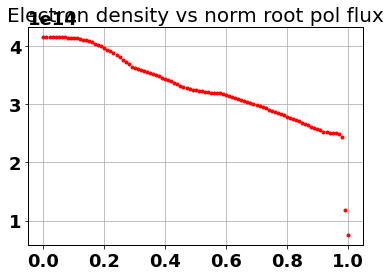

In [32]:
plt.plot(Psipol,equidt['tbne'],'r.');
plt.title('Electron density vs norm root pol flux')
plt.grid();


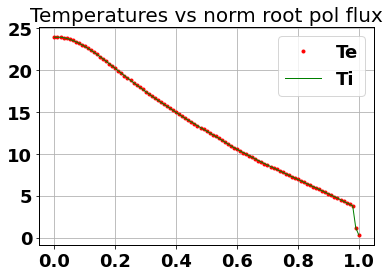

In [33]:
plt.plot(Psipol,equidt['tbte'],'r.',label='Te')
plt.plot(Psipol,equidt['tbi_provv'],'g',label='Ti')
plt.title('Temperatures vs norm root pol flux')
plt.legend()
plt.grid();

Note that  Conc in the aconc toric namelist is not in percent. This template is for full field D-T burn. For startup you may want to reduce alpha (4-He) concentration. Optimal 3-He concentration may be lower than 5% also.

Distances are in cm in namelist.

note write_profnt takes species info from namelist eq0_nml, but toric only reads from profnt for species if it exists

----

Using a previous Transp SPARC TORIC run as a template, we create a new input file. 

We keep ICRF settings on frequency, antenna, etc the same. Interested users may want to vary `nphi` for exploration of antenna phasing. 

`TORIC` has its own wall model with spacing for the wall and antenna specified relative to the LCF of the plasma. We give suggested values based on the actual SPARC wall and LCF for this case.

In SPARC, the antenna is at an absolute position of about 2.44m

distances plasma edge to wall (cm) ::   1 : outer; 2 : up; 3 : inner; 4 : down

Estimate values to use from LCF and SPARC wall.

### Write equidt.data file for profiles and toric.nml

In [48]:
from copy import deepcopy
eq0_nml=deepcopy(toricnml)

In [49]:
#the values set below are determined from settings in cell 1 or the equilibrium files
eq0_nml['toricainp']['nmod']=toric_mesh[1]/2-1
eq0_nml['toricainp']['ntt']=toric_mesh[1]
eq0_nml['toricainp']['nelm']=toric_mesh[0]
eq0_nml['toricainp']['mxmvac']=min(63,eq0_nml['toricainp']['nmod'])

In [50]:
eq0_nml['equidata']['inputpath']='./'
eq0_nml['equidata']['nspec']=nspec
eq0_nml['equidata']['equil_file']=eqdsk_file+'.equigs'
eq0_nml['equidata']['profnt_file']=eqdsk_file+'.equidt'

#note write_profnt takes species info from namelist eq0_nml, but toric only reads from profnt for 
#for species if it exists
write_profnt(eq0_nml,equidt,version='profnt2')

In [51]:
dist_plawall=(np.array(
     [np.max(eq0['rlim'])-np.max(eq0['rbbbs']),
      np.max(eq0['zlim'])-np.max(eq0['zbbbs']),
      -np.min(eq0['rlim'])+np.min(eq0['rbbbs']),
      -np.min(eq0['zlim'])+np.min(eq0['zbbbs']) ] )*100 ).tolist()
print("Values dist_plawall:", dist_plawall)

Values dist_plawall: [23.964259000000034, 51.741305999999994, 4.085172000000004, 51.61501]


In [52]:
eq0_nml['equidata']['dist_plawall']= dist_plawall
eq0_nml['equidata']['dist_plafars']= 2.0 # (np.max(eq0['rlim'])-np.max(eq0['rbbbs']))*100.-1.5 #faraday offset
eq0_nml['equidata']['dist_plaant']= 4.0 #(np.max(eq0['rlim'])-np.max(eq0['rbbbs']))*100.-0.5  #ant offset

In [53]:
np.max(rminor),eq0_nml['equidata']['dist_plawall'],eq0_nml['equidata']['dist_plafars'],eq0_nml['equidata']['dist_plaant']

(0.5072690061220002,
 [23.964259000000034, 51.741305999999994, 4.085172000000004, 51.61501],
 2.0,
 4.0)

The namelist variable `idprof` determines whether we use doubly parabolic analytic profiles or numerical ones. Here we handle the case of numerical profiles.

In [54]:
assert eq0_nml['equidata']['idprof']==1, f"idprof must be 1 to use profiles: {eq0_nml['equidata']['idprof']}"

Create profile inputs in the format toric uses.

In [55]:
eq0_nml['toricainp']['isol']=1  # 0 running diagnostic mode
eq0_nml['toricainp']['timing_on']=True
eq0_nml['toricainp']['nphi'] = int(kpar_ant*(eq0_nml['equidata']['dist_plaant']/100+rminor[-1]+Raxis) )

eq0_nml.write('torica.inp','w')

In [56]:
print('Toroidal mode of antenna is: ',eq0_nml['toricainp']['nphi'])

Toroidal mode of antenna is:  28


### Execute `TORIC`

In [58]:
#This will run at resolution of 400x63 in under a minute if nodes are free
#You can check that with sinfo
#alternatively run Storic.e for serial execution in about 4 minutes
#requires module load psfc/toric5
!cp /home/software/psfc/local/share/toric.slurm .

In [59]:
jobmessage=str(subprocess.run(["sbatch toric.slurm"], 
                   shell=True, stdout=subprocess.PIPE).stdout, "utf-8" )
print(jobmessage)
jobid=jobmessage.split()[-1]                
print('Job ID is: ',jobid)

Submitted batch job 45848291

Job ID is:  45848291


In [60]:
print('Job status is')
!squeue --job $jobid

Job status is
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          45848291 sched_mit    Toric jcwright  R       0:06      1 node550


In [61]:
print('Profiling and runtime')
!sacct  -j $jobid -o "JobName, Elapsed"

Profiling and runtime
   JobName    Elapsed 
---------- ---------- 
     Toric   00:00:11 
     batch   00:00:11 
    extern   00:00:11 
hydra_bst+   00:00:11 


In [ ]:
from importlib import reload  # Python 3.4+

toric = reload(toric)

In [ ]:
case2=toric.toric_analysis(mode='ICRF')

In [ ]:
case2.info()

In [ ]:
case2.plotpower();

In [ ]:
ispec=3
case2.plotpower(power='PwIF',species=ispec)
plt.xlim([0,1])
plt.title(spec_toric[ispec]['name']);

In [ ]:
case2.spectrum(cx=1)

In [ ]:
case2.plot_2Dfield('Eplus',logl=-20, im=True, scaletop=0.12);

In [ ]:
case2.plot_2Dfield('Eminus',logl=-20, im=True, scaletop=0.25);

In [ ]:
case2.plot_2Dfield('Re2Eminus',logl=20, scaletop=0.8);

### Make theta mesh from equilibrium

In [ ]:
eq=deepcopy(eq0)

In [ ]:
#routine for making equal arclength mesh. saved in file eqdsk_file+'.pkl'
def mapper(eqfile,jac):
    from scipy.signal import butter, filtfilt
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def find_cut(x,y, rmaxis, zmaxis):
  #adapted from S. Shiraiwai to find crossing going counter clockwise
  for k in range(len(y)-1):
       km = k-1
       if y[km] < zmaxis and y[k] > zmaxis:
         return k
  return -1


import scipy.integrate as integrate
import scipy.fftpack as sft
import scipy.interpolate as interpolate

eqfileobj=eqdsk_file+'.pkl' #mapping stored in pkl file
mu0=4.*np.pi*1.e-7
R=eq.get('r')
Z=eq.get('z')
B,grad_psi,fRZ,RR,ZZ=eqdsk.getModB(eq)
psi=eq.get('psizr').T
curtor=[]
area=[]


#Parameters
mapzmaxis=0.0
ifrhopol=True #use root psipol mesh instead of psipol (eg for torlh)
jac='straight' #'eqarc'

# get flux surface on fine rectangular mesh
newR=np.arange(min(R),max(R),0.01)
newZ=np.arange(min(Z),max(Z),0.01)
newZ=newZ-eq['zmaxis']  #axis needs to be at z=0 for mapping

RR_finer,ZZ_finer=np.mgrid [min(R):max(R):200j, min(Z):max(Z):200j ] #200x200 2D coordinate meshes

spline_psi = interpolate.RectBivariateSpline(R,Z,psi.T,bbox=[np.min(R),np.max(R),np.min(Z),np.max(Z)],kx=5,ky=5)
psi_int=spline_psi.ev(RR_finer,ZZ_finer)
psi_int_r=spline_psi.ev(RR_finer,ZZ_finer,dx=1)
psi_int_z=spline_psi.ev(RR_finer,ZZ_finer,dy=1)
grad_psi=np.sqrt(psi_int_z**2+psi_int_r**2)

#check for save
import pickle

if True:
  #generated mapped mesh size:
  npsi=128
  ntheta=128

  #we will have eq_theta at each filtered_cx,cy
  #like polar contour needed to be converted to regular mesh

#get psi mesh for surfaces for theta within LCF
#LCS is at psi=0
#drop first point, magnetic axis. We add this one manually since it cannot
#be contoured.

  #psimesh=eq['fluxGrid'][1:] #poloidal flux grid, created by readGEQDSK from eqdsk but not in eqdsk file
#resize psi to the number of desired psi levels, psimesh is already uniform
#initial psimesh is [-psimin,0].
#the following is only necessary if psimesh is not uniform which it should be for an eqdsk file.

  nidx=100
#reference psi
  fity=np.linspace(eq['simag'],eq['sibry'],nidx)

  if ifrhopol:
    rhopol = np.linspace(np.sqrt(np.abs(eq['simag'])),np.sqrt(np.abs(eq['sibry'])),nidx)*np.sign(fity)
    fity = rhopol**2*np.sign(fity) #reference psipol consistent with uniform rhopol
    #rhopol is linear so just declare it
    rhopol = np.linspace(0,1,npsi) 
    #rhopol = (rhopol-np.min(rhopol))/(np.max(rhopol)-np.min(rhopol)) #normalize
    eq['rhopolmap']=rhopol  #sqrt norm rho pol for map size npsi, linear spaced

  fitx = np.linspace(0,nidx,nidx)
#get psimesh
  fitxvals = np.linspace(0, nidx, npsi)
  psimesh = np.interp(fitxvals, fitx, fity) #this just stretches fity to size of npsi

  rmaxis = eq['rmaxis']
  zmaxis = mapzmaxis #eq['zmaxis']
  eq['psipolmap'] = psimesh

  c_pprime = np.interp( psimesh, eq['fluxGrid'], eq['pprime'] )
  c_ffprime = np.interp( psimesh, eq['fluxGrid'], eq['ffprim'] )

#Extract contours and values for flux coordinate system.
#contours go counter-clockwise, which we want
#contours don't necessarily start at y=0., so rebase
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.set_aspect('equal')
  fig.set_figheight(6)
  psi_cs=plt.contour(RR_finer,ZZ_finer,psi_int,levels=psimesh)
  #psi_cs=plt.contour(Rv,Zv,psi,levels=psimesh)

#Get Psi contours, careful to exclude field coils
  psixy=[]
  for p in psi_cs.collections:
      for pp in p.get_paths():
        v = pp.vertices
        x = v[:,0]
        y = v[:,1]
        if np.abs(np.average(y))<0.20*np.max(eq['z']): #only keep core plasma contours
          psixy.append( (x,y) )

#Define uniform theta mesh
  uni_theta=np.linspace(0,2.0*np.pi,ntheta,endpoint=False)

#Set up X(psi,theta) Y(psi,theta) and initialize with magnetic axis point
  eq_x=[]
  eq_y=[]

  #is there any reason for two meshes here?
  points = np.array( (RR_finer.flatten(), ZZ_finer.flatten()) ).T
  #points = np.array( (Rv.flatten(), Zv.flatten()) ).T
  gpsivalues = grad_psi.flatten()
  Bpoints = np.array( (RR.flatten(), ZZ.flatten()) ).T
  Bvalues   = B.flatten()

  from scipy.interpolate import griddata
  #print('points',points.shape,gpsivalues.shape)
  c_idx=-1
  minmodes = 8
  maxmodes = 20
  for cx,cy in psixy:
      c_idx+=1
      print('cx',c_idx, len(cx),len(psixy)) #just to see progress
      #for each surface, low pass filter to central 8+ DC Fourier modes
      #remove last element for fft since it is equal to the first element
      #size of (cx,cy) is  variable

      #shift to midplane as first element
      idx=find_cut(cx,cy,rmaxis,zmaxis)
      if (idx>=0):
          #now project to centers
          #this assumes that values stradle midplane which seems to be the 
          #case for python contour, but should be made more robust.
          cx=0.5*(np.roll(cx,-idx)+np.roll(cx,-idx+1))
          cy=0.5*(np.roll(cy,-idx)+np.roll(cy,-idx+1))

      #print('0',cy[0],cy[-1],cx[0],cx[-1],np.average(cy))

      #filter out high freq noise, esp needed near axis
      nmodes=max( minmodes,int(len(cx)/np.float(maxmodes) ))
      fftx=sft.fft(cx)
      fftx[int(nmodes/2)+1:-int(nmodes/2)]=0
      filtered_cx=sft.ifft(fftx).real
        
      ffty=sft.fft(cy)
      ffty[int(nmodes/2)+1:-int(nmodes/2)]=0
      
      #restore value for idx=0 for Y. 
      ffttotal=np.sum(ffty) #want to restore to total before filter.
      ffty[int(nmodes/2)+1]=-ffttotal/2.
      ffty[-int(nmodes/2)-1]=-ffttotal/2.

      filtered_cy=sft.ifft(ffty).real

    #interpolate |grad psi| and B onto this surface
    #this significantly slows down this routine. I think this can be moved outside of the 
    #loop if cx,cy are saved.

      print('1',filtered_cy[1],filtered_cy[0],filtered_cy[-1],filtered_cx[0])

      c_gradpsi = griddata( points, gpsivalues, (filtered_cx,filtered_cy), method='cubic' )
      c_B       = griddata( Bpoints,    Bvalues, (filtered_cx,filtered_cy), method='cubic' )

    #derivative from fft needs factor of 2pi
      df_dx=sft.diff(filtered_cx)*np.pi*2.0/len(filtered_cx)
      df_dy=sft.diff(filtered_cy)*np.pi*2.0/len(filtered_cy)
      dl=np.sqrt(df_dx**2+df_dy**2) #These two steps could be done with FFT too.

      #flux surface integrals here
      c_curtor = -integrate.simps(
          dl*filtered_cx/c_gradpsi * ( c_pprime[c_idx] + c_ffprime[c_idx]/filtered_cx**2/mu0 ) 
      )
      c_area = integrate.simps(
          dl/c_gradpsi
      )

      #if straight field line, multiply dl by 1/R*|gradpsi|
      if jac=='straight':
        dtheta=dl/np.abs(c_gradpsi*filtered_cx)
      else: #jac='eqarc'
        dtheta=dl
      L=integrate.cumtrapz(dtheta,initial=0)/len(dtheta) 
      
      #now put each on same theta mesh, Jacobian selection
      this_theta=L/np.max(L)*2.0*np.pi
      t_map=interpolate.interp1d(this_theta,filtered_cx,kind='cubic')
      eq_x.append(t_map(uni_theta))
      t_map=interpolate.interp1d(this_theta,filtered_cy,kind='cubic')
      eq_y.append(t_map(uni_theta))
      curtor.append (c_curtor)
      area.append( c_area )

  #add origin term
  area.insert(0,0.)          #area of origin is 0. 
  curtor.insert(0,curtor[0]) #current density maximum at origin
  curtor=np.array(curtor)
  area=np.array(area)
  Xmap=np.real(np.vstack(eq_x))
  Zmap=np.real(np.vstack(eq_y))
  eq['darea_dpsi']=area
  eq['dI_dpsi']=curtor
  
  #update npsi to # of actual contour surfaces
  npsi=len(psixy)+1
  #add origin
  NXmap=np.zeros([npsi,ntheta])
  NZmap=np.zeros([npsi,ntheta])
  NXmap[0,:]=eq['rmaxis'] #origin for all theta
  NZmap[0,:]=mapzmaxis #eq['zmaxis']
  NXmap[1:,:]=Xmap
  NZmap[1:,:]=Zmap

  #print("Error of axis is",100.*np.average(np.abs(Zmap[0,:]-mapzmaxis))/mapzmaxis )

  del(Xmap)
  del(Zmap)
  Xmap=NXmap
  Zmap=NZmap

  #smooth radial dependence with lowpass filter #this seems to introduce wiggles to theta lines
#  for ith in range(Zmap.shape[1]):
#    theZ=Zmap[:,ith]
#    theX=Xmap[:,ith]#

#    smoothZ = butter_lowpass_filtfilt(theZ,6,npsi)
#    smoothX = butter_lowpass_filtfilt(theX,6,npsi)
#    Zmap[:,ith]=smoothZ
#    Xmap[:,ith]=smoothX
  
  print('shapes of mapped arrays: ',Xmap.shape,Zmap.shape)
  #save this in pickle file
  eq['xmap']=Xmap
  eq['zmap']=Zmap
  

  import pickle  
  with open(eqfileobj, "wb")  as file_pi:
    pickle.dump([Xmap,Zmap,psixy,curtor,eq], file_pi);

else:
    try:
      Xmap,Zmap,psixy,curtor,eq = pickle.load(f)
      print('loaded previous mapping')
    finally:
        f.close()


In [ ]:
eq.keys()

In [ ]:
#Plot coordinate mesh

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
fig.set_figheight(20)

#Theta lines
for i in np.arange(0,len(Xmap[0,:]),5):
    plt.plot(Xmap[:,i],Zmap[:,i])
    
#Psi surface   
for i in np.arange(0,len(Xmap[:,0]),10):
    plt.plot(Xmap[i,:],Zmap[i,:])
plt.plot(Xmap[-1,:],Zmap[-1,:]);

plt.title('Surfaces of constant theta and psi (every 10th)');

In [ ]:
Xmap.shape, Zmap.shape

In [ ]:
!ls *.pkl